In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib
import os
import keras
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc,roc_curve,average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix,accuracy_score,precision_recall_curve
from funcsigs import signature
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Plot Function

## Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", fontsize=16, color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.tight_layout()

In [ ]:
cmte = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)
class_names = ['no', 'yes']
plt.figure()
plot_confusion_matrix(cmte, classes=class_names,title='Confusion matrix Neural Network Test')

cmtr = confusion_matrix(y_train, y_train_pred)
np.set_printoptions(precision=2)
class_names = ['no', 'yes']
plt.figure()
plot_confusion_matrix(cmtr, classes=class_names,title='Confusion matrix Neural Network Train')

## ROC_AUC

In [ ]:
def plot_roc_auc_curve(method,X_test,y_test, y_test_pred):
    y_probs = method.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of Neural Network')
    plt.show()

In [ ]:
plot_roc_auc_curve(method,X_test,y_test, y_test_pred)

## P_R Curve

In [ ]:
def plot_precision_recall_curve(method,X_test,y_test, y_test_pred):
    average_precision = average_precision_score(y_test, y_test_pred)
    disp = plot_precision_recall_curve(method, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Scores

In [ ]:
def report_scores(y_test, y_test_pred):
    
    f1 = f1_score(y_test, y_test_pred)
    accuracy= accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_pred)
    average_precision = average_precision_score(y_test, y_test_pred)
    
    return f1,accuracy,precision,recall,auc,average_precision

## Benchmark

In [ ]:
def benchmark(data, preprocessor, clf):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline
        
        clf : estimator
        
        name : str, default = None
        
        compare_to: DataFrame, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
    
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test":
            try:
                clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
            except (ValueError, TypeError):
                clf.fit(X_train, y_train)
                
        y_pred = clf.predict(X)
        
        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

# Loading Data

In [14]:
def split_dataset(data, preprocessor, random_state=82):
    """
    Split dataset into train, test and validation sets using preprocessor.
    Because the random state of validation set is not specified, the validation set will be different each time when the function is called.

    Parameters
    ----------
        data : DataFrame

        preprocessor : Pipeline

    Returns
    -------
        datasets : tuple

    Examples
    --------
        from sklearn.preprocessing import OrdinalEncoder
        data = import_dataset("../data/BankMarketing.csv").interpolate(method="pad").loc[:, ["job", "education", "y"]]
        # To unpack all train, test, and validation sets 
        X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack train and test sets.
        X_train, y_train, X_test, y_test, *other_sets = split_dataset(data, OrdinalEncoder())
        # To unpack test and validation set
        *other_sets, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack only train set.
        X_train, y_train, *other_sets = split_dataset(data, OneHotEncoder())
    """
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for train_index, test_index in train_test_split.split(data.drop("y", axis=1), data["y"]):
        train_set = data.loc[train_index].reset_index(drop=True)
        test_set = data.loc[test_index].reset_index(drop=True)

    y_train = train_set["y"].astype("int").to_numpy()
    y_test = test_set["y"].astype("int").to_numpy()
    X_train = preprocessor.fit_transform(train_set, y_train)
    X_test = preprocessor.transform(test_set)
        
    train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for ttrain_index, validate_index in train_validate_split.split(X_train, y_train):
        ttrain_set = train_set.loc[ttrain_index].reset_index(drop=True)
        validate_set = train_set.loc[validate_index].reset_index(drop=True)
    
    y_ttrain = ttrain_set["y"].astype("int").to_numpy()
    y_validate = validate_set["y"].astype("int").to_numpy()
    X_ttrain = preprocessor.fit_transform(ttrain_set, y_ttrain)
    X_validate = preprocessor.transform(validate_set)
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        X_ttrain = X_ttrain.to_numpy()
        X_validate = X_validate.to_numpy()

    return (X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate)

In [9]:
def import_dataset(filename):
    """
    Import the dataset from the path.

    Parameters
    ----------
        filename : str
            filename with path

    Returns
    -------
        data : DataFrame

    Examples
    --------
        bank_mkt = import_dataset("../data/BankMarketing.csv")
    """
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "category",
                                      "day_of_week": "category",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop 12 duplicated rows
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    bank_mkt["month"] = bank_mkt["month"].cat.reorder_categories(["mar", "apr", "jun", "jul", "may", "aug", "sep", "oct", "nov", "dec"], ordered=True)
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].cat.reorder_categories(["mon", "tue", "wed", "thu", "fri"], ordered=True)
    return bank_mkt

In [23]:
def benchmark(data, preprocessor, clf):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline
        
        clf : estimator
        
        name : str, default = None
        
        compare_to: DataFrame, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
    
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test":
            try:
                clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
            except (ValueError, TypeError):
                clf.fit(X_train, y_train)
                
        y_pred = clf.predict(X)
        
        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

In [25]:
def cat_encode(X,
               drop=["duration", "y"],
               cut=None,
               cyclic=None,
               target=None):
    """
    Encode and transform categorical data into numerical values.
    
    Parameters
    ----------
        X : DataFrame
        
        drop : list, default = ["duration", "y"]
        
        cut : list
        
        cyclic : list
        
        target : list
    
    Returns
    -------
        X : DataFrame

    Examples
    --------
    bank_mkt = import_dataset("../data/BankMarketing.csv")
    X = cat_encode(bank_mkt)
    """
    X = X.copy()
    
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3.
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    X["month"] = X["month"].replace(month_map).astype("Int64")
    
    if cut != None:
        if "pdays" in cut:
            X["pdays"] = X["pdays"].fillna(-1)
            # Clients who have been contacted but do not have pdays record
            X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
            # Cut pdays into categories
            X["pdays"] = pd.cut(X["pdays"], [0, 3, 5, 10, 15, 30, 1000], labels=[3, 5, 10, 15, 30, 1000], include_lowest=True).astype("Int64")
    else:
        # Fill missing values in pdays as 999
        X["pdays"] = X["pdays"].fillna(999)
    
    if cyclic != None:
        if "month" in cyclic:
            X['month_sin'] = np.sin(2 * np.pi * X["month"]/12)
            X['month_cos'] = np.cos(2 * np.pi * X["month"]/12)
            X = X.drop("month", axis=1)
        if "day_of_week" in cyclic:
            X["day_of_week"] = X["day_of_week"].cat.codes
            X['day_sin'] = np.sin(2 * np.pi * X["day_of_week"]/5)
            X['day_cos'] = np.cos(2 * np.pi * X["day_of_week"]/5)
            X = X.drop("day_of_week", axis=1)
    
    # Transform target encoded feature as str
    if target != None:
        X[target] = X[target].astype("str")
        
    # Drop features
    X = X.drop(drop, axis=1)
    
    # Other categorical features will be coded as its order in pandas categorical index
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    
    # Fill missing values as -1
    X = X.fillna(-1)
    
    return X

In [24]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [ ]:
cat_encoder = FunctionTransformer(cat_encode)

freq_features = ["job", "marital", "education", "default", "housing", "loan"]

freq_imputer = ColumnTransformer([
    ("freq_imputer", SimpleImputer(missing_values=-1, strategy="most_frequent"), freq_features)
], remainder="passthrough")

freq_encoder = make_pipeline(cat_encoder, freq_imputer)

In [ ]:
X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(bank_mkt, freq_encoder)

In [ ]:
mlp=MLPClassifier(solver ="adam",random_state=42,max_iter=1000)
benchmark(bank_mkt, freq_encoder, mlp)

# Train / Test /Validation

In [4]:
mlp=MLPClassifier(solver ="adam",random_state=42,max_iter=1000)
mlp.fit(X_train, y_train)
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

# GridSearchCV

In [ ]:
mlp=MLPClassifier(solver ="adam",random_state=42,max_iter=1000)


scoring = {'AUC': 'roc_auc', 
           'Accuracy': make_scorer(accuracy_score),
           'Average_Precision':make_scorer(average_precision_score)
           }

param_grid ={
    'learning_rate':["constant","invscaling","adaptive"],
    'hidden_layer_sizes':[(1,5),(2,5),(3,5)],
    'alpha':[0.0,0.0001,0.001,0.01],
    'activation' :["logistic","relu","tanh"] }

CV_nnmodel = GridSearchCV(estimator=mlp,
                          param_grid=param_grid,
                          scoring = scoring,
                          return_train_score=True,
                          refit = 'AUC',
                          cv =3,
                          n_jobs=-1) 
       
CV_nnmodel.fit(X_train,y_train)
parameters = CV_nnmodel.best_params_
scores =CV_nnmodel.best_score_

In [ ]:
# Test the Trained Model on Test Set
mlp_adam=MLPClassifier(solver="adam",
                       random_state=42,
                       activation = 'relu',
                       alpha = 0.01,
                       hidden_layer_sizes = (3,5),
                       learning_rate = 'constant')
mlp_adam.fit(X_train,y_train)
y_train_pred = mlp_adam.predict(X_train)
y_test_pred= mlp_adam.predict(X_test)

In [ ]:
mlp_sgd=MLPClassifier(solver ="sgd",random_state=42,max_iter=1000)

scoring = {'AUC': 'roc_auc', 
           'Accuracy': make_scorer(accuracy_score),
           'Average_Precision':make_scorer(average_precision_score)
           }

param_grid ={
    'learning_rate':["constant","invscaling","adaptive"],
    'hidden_layer_sizes':[(1,5),(2,5),(3,5)],
    'alpha':[0.0,0.0001,0.001,0.01],
    'activation' :["logistic","relu","tanh"] }

CV_nnmodel = GridSearchCV(estimator=mlp_sgd,
                          param_grid=param_grid,
                          scoring = scoring,
                          return_train_score=True,
                          refit = 'AUC',
                          cv =3,
                          n_jobs=-1) 
       
CV_nnmodel.fit(X_train,y_train)
parameters = CV_nnmodel.best_params_
scores =CV_nnmodel.best_score_

In [ ]:
# Test the Trained Model on Test Set
mlp_sgd=MLPClassifier(solver="sgd",
                      random_state=42,
                      activation = 'relu',
                      alpha = 0.01,
                      hidden_layer_sizes = (3,5),
                      learning_rate = 'constant')
mlp_sgd.fit(X_train,y_train)
y_train_pred = mlp_sgd.predict(X_train)
y_test_pred= mlp_sgd.predict(X_test)

# Neural Network with Keras

In [5]:
model = Sequential()
model.add(Dense(16, input_dim=34, activation='relu'))
model.add(Dense(7, activation='relu'))
#model.add(Dropout(0.6))
#model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['binary_accuracy'])

In [6]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=120, 
                    batch_size=275)

Epoch 1/120
120/120 [==============================] - 0s 2ms/step - loss: 0.3711 - binary_accuracy: 0.8891
Epoch 2/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2992 - binary_accuracy: 0.8973
Epoch 3/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2907 - binary_accuracy: 0.8981
Epoch 4/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2872 - binary_accuracy: 0.8981
Epoch 5/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2851 - binary_accuracy: 0.8985
Epoch 6/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2836 - binary_accuracy: 0.8992
Epoch 7/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2825 - binary_accuracy: 0.8996
Epoch 8/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2815 - binary_accuracy: 0.8996
Epoch 9/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2807 - binary_accuracy: 0.9003
Epoch 10/120
120/120 [======

In [8]:
# Transforming probabilities into 1/0
y_pred = model.predict(X_test)
y_prediction = []
for i in y_pred:
    if i > 0.5:
        y_prediction.append(1)
    else:
        y_prediction.append(0)

In [9]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=120, batch_size=275)

Epoch 1/120
120/120 [==============================] - 0s 3ms/step - loss: 0.2693 - binary_accuracy: 0.9023 - val_loss: 0.2727 - val_binary_accuracy: 0.9001
Epoch 2/120
120/120 [==============================] - 0s 2ms/step - loss: 0.2694 - binary_accuracy: 0.9023 - val_loss: 0.2724 - val_binary_accuracy: 0.9009
Epoch 3/120
120/120 [==============================] - 0s 2ms/step - loss: 0.2694 - binary_accuracy: 0.9024 - val_loss: 0.2724 - val_binary_accuracy: 0.9005
Epoch 4/120
120/120 [==============================] - 0s 3ms/step - loss: 0.2692 - binary_accuracy: 0.9021 - val_loss: 0.2724 - val_binary_accuracy: 0.9009
Epoch 5/120
120/120 [==============================] - 0s 2ms/step - loss: 0.2693 - binary_accuracy: 0.9019 - val_loss: 0.2727 - val_binary_accuracy: 0.9003
Epoch 6/120
120/120 [==============================] - 0s 1ms/step - loss: 0.2692 - binary_accuracy: 0.9019 - val_loss: 0.2725 - val_binary_accuracy: 0.9005
Epoch 7/120
120/120 [==============================] - 0s 

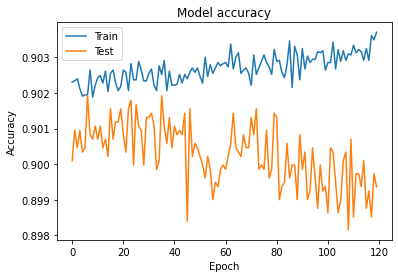

In [10]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

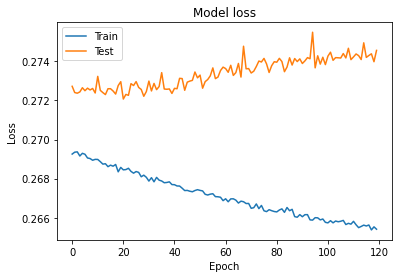

In [11]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()